<a href="https://colab.research.google.com/github/Sandblaze05/video_analytics_fog/blob/main/Video_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing video: /content/drive/MyDrive/Dataset/2099536-hd_1920_1080_30fps.mp4
Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to ge

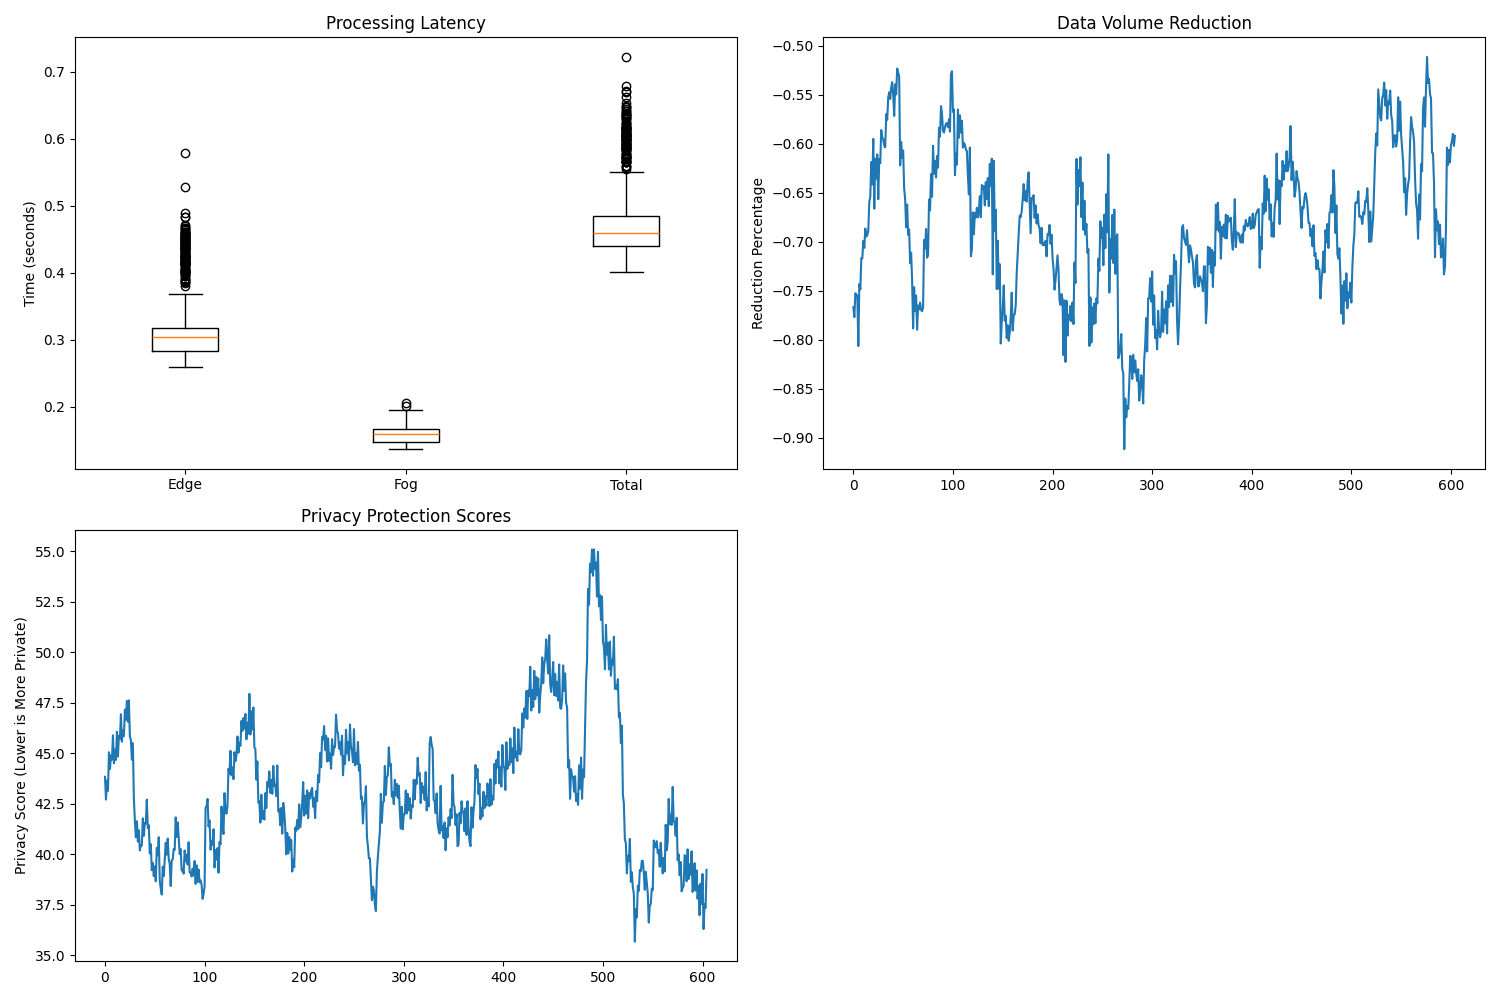

Simulation complete!


In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision
import torchvision.models as models
import time
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
from tqdm import tqdm

class VideoAnalyticsSim:
    def __init__(self):
        # Check for GPU availability
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        # Simulated edge device model (lightweight detection)
        self.edge_model = models.detection.ssd300_vgg16(pretrained=True).to(self.device).eval()

        # Simulated fog node model (advanced processing)
        self.fog_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(self.device).eval()

        # Metrics tracking
        self.metrics = {
            'edge_processing_time': [],
            'fog_processing_time': [],
            'total_latency': [],
            'data_reduction': [],
            'privacy_scores': []
        }

    def _preprocess_frame(self, frame):
        # Convert frame to tensor, normalize, etc.
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
        return transform(frame).unsqueeze(0).to(self.device)

    def simulate_edge_processing(self, frame):
        start_time = time.time()

        # Preprocess frame
        input_tensor = self._preprocess_frame(frame)

        # Lightweight object detection
        with torch.no_grad():
            detections = self.edge_model(input_tensor)[0]

        # Privacy protection simulation
        obfuscated_frame = self._apply_privacy_protection(frame)

        processing_time = time.time() - start_time
        self.metrics['edge_processing_time'].append(processing_time)

        return obfuscated_frame, detections

    def simulate_fog_processing(self, obfuscated_frame):
        start_time = time.time()

        # Preprocess obfuscated frame
        input_tensor = self._preprocess_frame(obfuscated_frame)

        # Advanced object tracking and classification
        with torch.no_grad():
            advanced_detections = self.fog_model(input_tensor)[0]

        processing_time = time.time() - start_time
        self.metrics['fog_processing_time'].append(processing_time)

        return advanced_detections

    def _apply_privacy_protection(self, frame):
        # Simulate privacy protection by adding noise and blurring
        noisy_frame = frame + np.random.normal(0, 0.1, frame.shape)
        blurred_frame = cv2.GaussianBlur(noisy_frame.astype(np.float32), (15, 15), 0)

        # Calculate and store privacy score (lower is more private)
        privacy_score = self._calculate_privacy_score(frame, blurred_frame)
        self.metrics['privacy_scores'].append(privacy_score)

        return blurred_frame

    def _calculate_privacy_score(self, original, obfuscated):
        # Simple privacy score calculation using Mean Squared Error
        return np.mean((original - obfuscated) ** 2)

    def run_simulation(self, video_path):
        # Open video capture
        cap = cv2.VideoCapture(video_path)

        # Get total number of frames for progress bar
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Progress bar
        for _ in tqdm(range(total_frames), desc="Processing Frames"):
            ret, frame = cap.read()
            if not ret:
                break

            # Simulate edge processing
            start_total_time = time.time()
            obfuscated_frame, edge_detections = self.simulate_edge_processing(frame)

            # Simulate fog processing
            fog_detections = self.simulate_fog_processing(obfuscated_frame)

            # Calculate total latency
            total_latency = time.time() - start_total_time
            self.metrics['total_latency'].append(total_latency)

            # Improved data reduction calculation
            original_resolution = frame.shape[0] * frame.shape[1]
            obfuscated_resolution = obfuscated_frame.shape[0] * obfuscated_frame.shape[1]

            # Calculate information density reduction
            original_entropy = self._calculate_entropy(frame)
            obfuscated_entropy = self._calculate_entropy(obfuscated_frame)

            # Data reduction based on entropy and resolution
            resolution_reduction = (1 - obfuscated_resolution / original_resolution) * 100
            entropy_reduction = (1 - obfuscated_entropy / original_entropy) * 100

            data_reduction = (resolution_reduction + entropy_reduction) / 2
            self.metrics['data_reduction'].append(data_reduction)

        cap.release()

    def _calculate_entropy(self, frame):
        """
        Calculate image entropy as a measure of information content

        Args:
            frame (numpy.ndarray): Input image frame

        Returns:
            float: Entropy value representing information content
        """
        # Convert to grayscale if color image
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Calculate histogram
        hist = cv2.calcHist([frame], [0], None, [256], [0, 256])
        hist = hist / hist.sum()

        # Calculate entropy
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        return entropy

    def visualize_metrics(self):
        plt.figure(figsize=(15, 10))

        # Latency Breakdown
        plt.subplot(2, 2, 1)
        plt.title('Processing Latency')
        plt.boxplot([
            self.metrics['edge_processing_time'],
            self.metrics['fog_processing_time'],
            self.metrics['total_latency']
        ], labels=['Edge', 'Fog', 'Total'])
        plt.ylabel('Time (seconds)')

        # Data Reduction
        plt.subplot(2, 2, 2)
        plt.title('Data Volume Reduction')
        plt.plot(self.metrics['data_reduction'])
        plt.ylabel('Reduction Percentage')

        plt.subplot(2, 2, 3)
        plt.title('Privacy Protection Scores')
        plt.plot(self.metrics['privacy_scores'])
        plt.ylabel('Privacy Score (Lower is More Private)')

        plt.tight_layout()
        plt.savefig('/content/video_analytics_metrics.png')
        plt.close()

def main():
    drive.mount('/content/drive')
    video_path = '/content/drive/MyDrive/Dataset/2099536-hd_1920_1080_30fps.mp4'

    if video_path:
        print(f"Processing video: {video_path}")
        sim = VideoAnalyticsSim()
        sim.run_simulation(video_path)
        sim.visualize_metrics()

        # Show metrics image
        from IPython.display import Image
        display(Image('/content/video_analytics_metrics.png'))

        print("Simulation complete!")
    else:
        print("No video uploaded. Please try again.")

main()